# Accessing and using BARRA2 and BARPA data for research

## BARRA2

Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for 
Australia - Version 2 (BARRA2) is a reanalysis from 1979 to the present day covering Australia, New Zealand and a portion of South-East Asia.

## BARPA

The Bureau of Meteorology Atmospheric Regional Projections for Australia (BARPA) delivers high-resolution dynamical downscaling of CMIP6 experiments over CORDEX-Australasia and Australian domains.

## NCI

Both these datasets are hosted at NCI on Gadi. Additional information on these datasets can be found in NCI's documentation pages for [BARPA](https://opus.nci.org.au/pages/viewpage.action?pageId=264241161https://opus.nci.org.au/pages/viewpage.action?pageId=264241161) and [BARRA2](https://opus.nci.org.au/pages/viewpage.action?pageId=264241166https://opus.nci.org.au/pages/viewpage.action?pageId=264241166).

<font color='red'>TODO add reference to OPUS pages for this workshop?</font>

## Accessing BARRA2 & BARPA

The outputs for BARRA2 and BARPA are store at NCI in the ob53 and py18 projects respectively.
Access to these projects can be requested in the usual way at the NCI account management pages - https://my.nci.org.au/mancini
The files are also available for direct download from NCI's Thredds server:
- [BARRA2](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/ob53/catalog.xml)
- [BARPA](https://dap.nci.org.au/thredds/remoteCatalogService?catalog=https://dapds00.nci.org.au/thredds/catalogs/py18/catalog.xml)

### List of variables

A list of the variables used by BARPA and BARRA2 can be found [here](https://github.com/joshuatorrance/barpa-barra2-amos2024/blob/main/BARRA2_BARPA_variable_list.csvhttps://github.com/joshuatorrance/barpa-barra2-amos2024/blob/main/BARRA2_BARPA_variable_list.csv).

***
This notebook covers some basic interactions with BARPA and BARRA2 data and some simple manipulations using *xarray*.

For more information on the multitude of tools available with *xarray* check out the xarray documentation:
https://docs.xarray.dev/en/stable/getting-started-guide/index.html
***

## Loading BARRA/BARPA data with Xarray & Dask

First we load the required python modules and start a dask client to speed up our computation.

In [4]:
# Imports for the notebook
import os
from glob import glob
from datetime import datetime
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cartopy.crs
import dask.distributed

In [3]:
# Let's explictly load dask so we can check progress
# Copy and paste the dashboard link/path from this cell's output
# to the Dask tab on the left.
client = dask.distributed.Client()
client

/opt/conda/envs/datasci/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38191 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38191/status,
Dashboard: /proxy/38191/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44147,Workers: 7
Dashboard: /proxy/38191/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36341,Total threads: 1
Dashboard: /proxy/38647/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:34333,


There should now be a dask client running (click on "Launch dashboard in JupyterLab" to see the dashboard). The dask client will allow for better parallelisation of xarray operations such as opens multiple files or processing large datasets.

You can see the progress of dask operations in the dask dashboard.

***
Next we will build a path to the BARPA or BARRA2 data.

In [18]:
## Data location
# Let's define the path to the files we're interested in
# BARRA2
barra_r2_root_path = "/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1"

# BARPA
barpa_top_path = "/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM"
barpa_model = "ACCESS-CM2"
    # One BARPA model out of:
    # ACCESS-CM2, ACCESS-ESM1-5, CESM2, CMCC-ESM2, EC-Earth3, ERA5, MPI-ESM1-2-HR, NorESM2-MM
barpa_scenario = "historical"
barpa_root_path = f"{barpa_top_path}/{barpa_model}/{barpa_scenario}/*/BARPA-R/v1-r1"

### Pick the root path that interests you, either BARPA or BARRA2, comment out the other one. ###
root_path = barra_r2_root_path
#root_path = barpa_root_path

## Time resolution
# e.g. BARRA - mon, day, 3hr, 1hr
#      BARPA - mon, day, 6hr, 1hr
time_resolution = "1hr"

## Variable
# Choose the variable to look at, e.g. "ts" for surface temperature
var = "ts"

## Date (YYYYMM)
# With glob we can use wild cards to find the files we want
# e.g. "2014??" for all of 2014 or "20140[123]" for the first three months
# Note that BARRA2 data has one file per month, BARPA data has one file per year
date = "2014??"

# Build a string to use with glob
glob_str = os.path.join(root_path, time_resolution, var, "*", f"*{date}.nc")

# Pass the string to glob will will return a matching list of file paths
file_list = sorted(glob(glob_str))

In [19]:
# Open the dataset

# If we have a single file we can use open_dataset
#ds = xr.open_dataset(file_list[0])

# If we have a list of files we use open_mfdataset
# Use parallel=True to take advantage of Dask's multiprocessing
ds = xr.open_mfdataset(file_list, parallel=True)

In [20]:
ds

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(744, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [21]:
ds[var].attrs

{'long_name': 'Surface Temperature',
 'standard_name': 'surface_temperature',
 'units': 'K',
 'cell_methods': 'time: point (interval: 1H)'}

## loaddata.py
loaddata.py is a module included with these notebooks to simplify access to BARPA and BARRA2 data.

More details and examples on this module can be found in the loaddata_demo notebook.

In [8]:
# First define the location where you have clone the repository
# TODO: auto build expected path to repo -> copy to other notebooks
notebook_dir = "/home/548/jt4085/repos/BARRA2_evaluation/jt/notebooks"
#notebook_dir = f"/scratch/om02/{os.environ['USER']}/repos/BARRA2_evaluation/jt/notebooks"
# Now change the notebooks working directory to this location
os.chdir(notebook_dir)

# Now we can load the module
import loaddata

In [9]:
# Load some BARRA data
ds = loaddata.load_barra2_data("BARRA-R2", "1hr", "ts", tstart=datetime(2014, 1, 1), tend=datetime(2015, 1, 1))
ds

<xarray.Dataset>
Dimensions:  (time: 8761, lat: 646, lon: 1082)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-01-01T01:00:00 ... 2015-01-01
  * lat      (lat) float64 -57.97 -57.86 -57.75 -57.64 ... 12.76 12.87 12.98
  * lon      (lon) float64 88.48 88.59 88.7 88.81 ... 207.1 207.2 207.3 207.4
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(744, 646, 1082), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

In [10]:
# Load some BARPA data
ds = loaddata.load_barpa_data("BARPA-R", "ACCESS-CM2", "historical", "1hr", "ts", tstart=datetime(2014, 1, 1), tend=datetime(2015, 1, 1))
ds

<xarray.Dataset>
Dimensions:  (time: 8760, lat: 436, lon: 777)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
Data variables:
    ts       (time, lat, lon) float64 dask.array<chunksize=(8760, 436, 777), meta=np.ndarray>
Attributes: (12/57)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               RCM
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science, Atmosphere; Continent, Australi...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; historical; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    date_modified:             2023-11-16T17:10:01Z
    date_metadata_modified:    2023-11-16T17:10:01Z

#### Load data contains some other helpful functions
Here's a couple of them

In [11]:
# Check a particular variable
_ = loaddata.whatis('1hr', 'pr')

Short name: pr
long_name: Precipitation
standard_name: precipitation_flux
units: kg m-2 s-1
cell_methods: time: mean (interval: 1 hour)


In [26]:
# List the available variables
_ = loaddata.list_barra2_variables('BARRA-R2', '1hr')

rsut, rluscs, ta1500m, va400, pr, ta200m, ta700, clwvi, hus500, tas, uasmean, mrsos, ua400, zg925, ta250m, rlus, prc, va150m, ua300, zg300, zg400, zg850, ua850, va250m, va200m, ta600, rsdscs, wa300, ua50m, hus200, ps, ta50m, omega500, prsn, va600, tasmean, cll, hus400, vasmean, wa700, wsgsmax, uasmax, vasmax, ua250m, CAPE, va850, ua700, ua1000, hus1000, ua200m, va700, hus950, ua150m, ua1500m, prw, va300, wa1000, ua600, ua100m, ua925, zg200, wa600, va100m, va200, rsutcs, rsds, evspsblpot, hus600, zg1000, ua500, sfcWind, mrfsos, hfls, ta850, ta100m, ua200, rsdt, clh, va925, zg600, hus300, zg500, hurs, psl, ts, vas, huss, rldscs, ta925, ta150m, wa500, va1500m, uas, hus700, ta500, zg700, clivi, wa200, va50m, ta200, rlutcs, tasmin, ta300, clm, CIN, ta400, rlds, wa400, zmla, va1000, rsdsdir, rsuscs, hfss, rlut, wa850, ta1000, va500, clt, ta950, wa925, tasmax, hus850, rsus, hus925


***
### Instantaneous vs. Accumulated variables
The variables used in BARPA and BARRA2 can be separated into two group, *instantaneous* and *accumulated*.

*Instantaneous* variables give a snapshot of the underlying model stat at the given time.

*Accumulated* variables give an aggregate view of a given time window (e.g. hourly mean, daily max).

It's important to note that time values are different between instantaneous and accumulated variables.
For instantaneous variables the time value match the start of the window when snapshot was taken, i.e. 00:00, 01:00.
Accumulated variables use time values in the centre of their window, i.e. 00:30, 01:30.

It's important to keep these different time values in mind if one if combining variables in some way.

In [12]:
var = 'tas'
ds_inst = loaddata.load_barra2_data("BARRA-R2", "1hr", var, tstart=datetime(2014, 1, 1), tend=datetime(2015, 1, 1))
print(ds_inst[var].attrs['long_name'])
# TODO: add whatis here and below, or as an exercise?
ds_inst['time'][0].data

Near-Surface Air Temperature


array('2014-01-01T00:00:00.000000000', dtype='datetime64[ns]')

In [31]:
var = 'tasmax'
ds_accum = loaddata.load_barra2_data("BARRA-R2", "1hr", var, tstart=datetime(2014, 1, 1), tend=datetime(2015, 1, 1))
print(ds_accum[var].attrs['long_name'])
ds_accum['time'][0].data

Hourly Maximum Near-Surface Air Temperature


array('2014-01-01T00:30:00.000000000', dtype='datetime64[ns]')

***
### Indexing and Plotting Data
Xarray has sophisticated indexing tools available.
There are many ways to index data with Xarray, below are a couple of examples.

See Xarray's [documentation](https://docs.xarray.dev/en/latest/user-guide/indexing.html) for more details.

Xarray data sets can be easily plotting with matplotlib.

In [13]:
var = 'ts'
ds = loaddata.load_barra2_data("BARRA-R2", "1hr", var, tstart=datetime(2014, 1, 1), tend=datetime(2015, 1, 1))

#### First timestep

In [14]:
# Select the first timestep
ds_first_timestep = ds.isel(time=0)

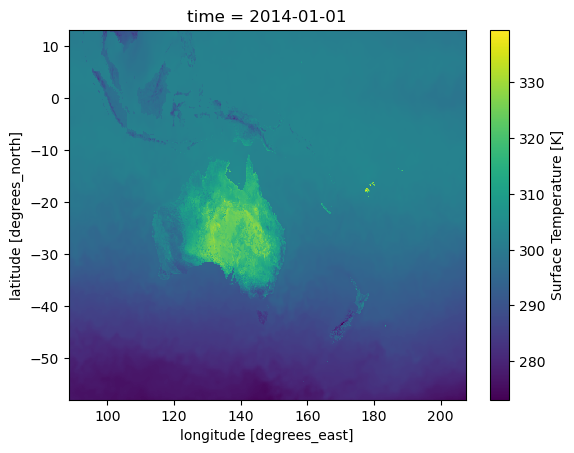

In [15]:
# Plot the first field

# Can only plot data arrays (not datasets)
da = ds_first_timestep[var]
da.plot()

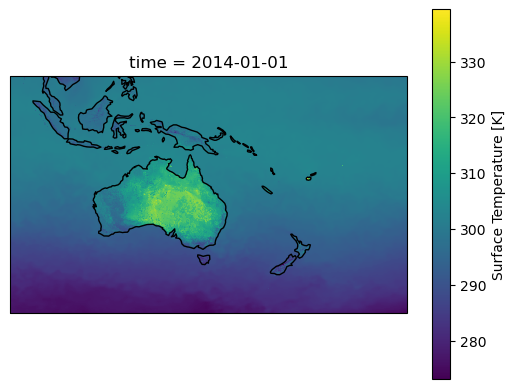

In [16]:
# Plot the first field - with coastlines!

# Can only plot data arrays (not datasets)
da = ds_first_timestep[var]

# Build a cartopy projection so we can draw on the coastlines
centre_lon = da['lon'].mean().values
projection = cartopy.crs.PlateCarree(central_longitude=centre_lon)

# Now plot the field with the transform.
p = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection})

# Draw the coastlines using cartopy
p.axes.coastlines()

#### Zoom in on Melbourne

In [19]:
# Select the Melbourne region with slice
# TODO: add more comments
melb_lat, melb_lon = -37.840935, 144.946457
width = 0.75
ds_melb = ds.sel(lat=slice(melb_lat - width, melb_lat + width),
                 lon=slice(melb_lon - width, melb_lon + width))

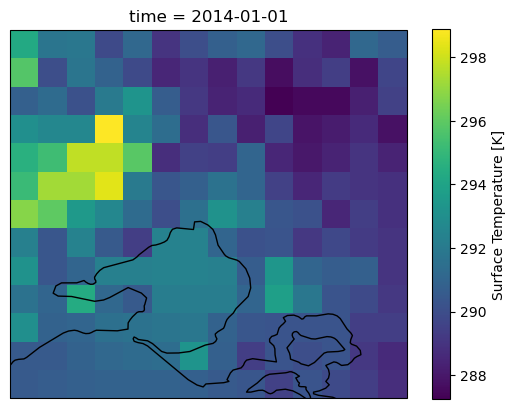

In [18]:
da = ds_melb.isel(time=0)[var]
centre_lon = da['lon'].mean().values
projection = cartopy.crs.PlateCarree(central_longitude=centre_lon)
p = da.plot(
    transform=cartopy.crs.PlateCarree(),
    subplot_kws={"projection": projection, "facecolor": "gray"})
p.axes.coastlines()

#### Mean temperature in Melbourne during 2014

Text(0.5, 1.0, 'Mean Surface Temperature in Melbourne region (K)')

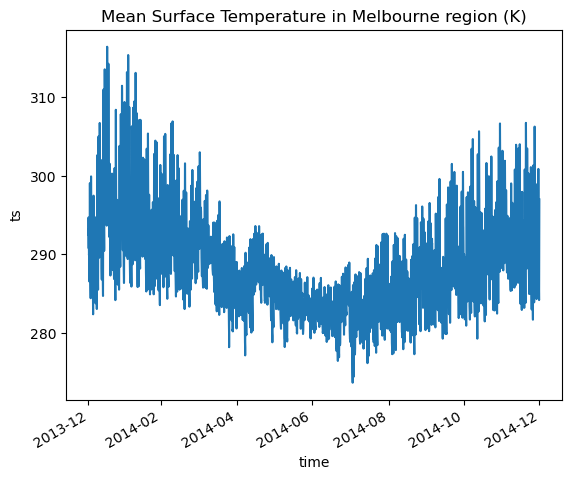

In [20]:
ds_melb[var].mean(dim=['lat', 'lon']).plot()

plt.title(f"Mean {da.attrs['long_name']} in Melbourne region ({da.attrs['units']})")

#### Exercise
1. Plot the average temperature in Melbourne by time-of-day
2. Plot the min and max daily temperatures in Melbourne

In [21]:
# Let's get the local Melb time as we'll need it soon
# Add the timezone, convert it to Melb, remove the timezone
time_melb = pandas.to_datetime(ds_melb['time']).tz_localize('UTC').tz_convert('Australia/Melbourne').tz_localize(None)

# And add it back into the Dataset as a new coordinate
ds_melb = ds_melb.assign_coords(time_melb=("time", time_melb))

In [22]:
ds_melb

<xarray.Dataset>
Dimensions:    (time: 8761, lat: 13, lon: 14)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01 ... 2015-01-01
  * lat        (lat) float64 -38.5 -38.39 -38.28 -38.17 ... -37.4 -37.29 -37.18
  * lon        (lon) float64 144.2 144.4 144.5 144.6 ... 145.3 145.5 145.6 145.7
    time_melb  (time) datetime64[ns] 2014-01-01T11:00:00 ... 2015-01-01T11:00:00
Data variables:
    ts         (time, lat, lon) float64 dask.array<chunksize=(744, 13, 14), meta=np.ndarray>
Attributes: (12/56)
    axiom_version:             0.1.0
    axiom_schemas_version:     0.1.0
    axiom_schema:              cordex-1H.json
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               reanalysis
    source:                    Data from Met Office Unified Model (UM) and Jo...
    ...                        ...
    creator_institution:       Bureau of Meteorology
    keywords:                  Earth Science Services, Models, EARTH SCIENCE ...
    title:                     Bureau of Meteorology Atmospheric high-resolut...
    summary:                   The Bureau of Meteorology Atmospheric high-res...
    date_modified:             2023-11-17T02:07:25Z
    date_metadata_modified:    2023-11-17T02:07:25Z

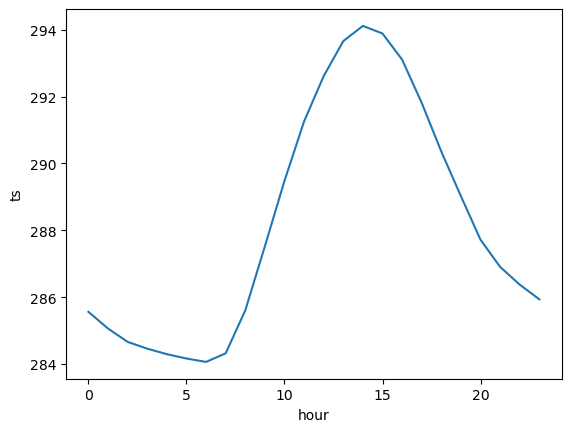

In [23]:
# Now plot the mean field value, averaged over each hour of the day
ds_melb[var].mean(dim=['lat', 'lon']).groupby("time_melb.hour").mean().plot()

In [24]:
# Daily min and max is usually from 9am to 9am
# Offset to 9am
# Let's continue taking the field mean to give an indicative daily max value for Melb
ds_melb.resample({'time_melb': '1D'}, offset='+9H').max().mean(dim=['lat', 'lon'])[var].plot()
ds_melb.resample({'time_melb': '1D'}, offset='+9H').min().mean(dim=['lat', 'lon'])[var].plot()
ds_melb.mean(dim=['lat', 'lon'])[var].plot(alpha=0.6)

KeyError: 'time_melb'

In [44]:
xr.__version__

'2023.2.0'

In [46]:
ds_melb._indexes

{'time': PandasIndex(DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
                '2014-01-01 02:00:00', '2014-01-01 03:00:00',
                '2014-01-01 04:00:00', '2014-01-01 05:00:00',
                '2014-01-01 06:00:00', '2014-01-01 07:00:00',
                '2014-01-01 08:00:00', '2014-01-01 09:00:00',
                ...
                '2014-12-31 15:00:00', '2014-12-31 16:00:00',
                '2014-12-31 17:00:00', '2014-12-31 18:00:00',
                '2014-12-31 19:00:00', '2014-12-31 20:00:00',
                '2014-12-31 21:00:00', '2014-12-31 22:00:00',
                '2014-12-31 23:00:00', '2015-01-01 00:00:00'],
               dtype='datetime64[ns]', name='time', length=8761, freq=None)),
 'lat': PandasIndex(Float64Index([ -38.5, -38.39, -38.28, -38.17, -38.06, -37.95, -37.84, -37.73,
               -37.62, -37.51,  -37.4, -37.29, -37.18],
              dtype='float64', name='lat')),
 'lon': PandasIndex(Float64Index([   144.25,    144.36,    144